# Tuning a `multi_match` `best_fields` query

The following assumes familiarity with the first notebook "Query tuning".

The first query type we used was a `multi_match` `cross_fields` query. This searches for query terms individually across each of the three document fields. For example, given a query string "impact of the success of the manhattan project", we search for each of the query terms in each of the fields. So we could have "impact" matching the body only, while "manhattan" could match all three fields. Due to the nature of the queries which are all questions, this might not be the best query type to use.

In this step, we're going to try using the `multi_match` query of type `best_fields`, which is the default query type for `multi_match`. This variant will look across fields but will only return the field and score with the best matches. We will also experiment in this query with modifying a few parameters of the query that are sometimes hard to guess at. Specifically, we'll explore which field boosts to use for each of our three fields and also which `tie_breaker` parameter to use.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import os
import sys

from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [3]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev, optimize_query_mrr100
from qopt.optimize import Config

In [11]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
# es = Elasticsearch('http://localhost:9200')
es = Elasticsearch('http://35.234.93.126:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
# max_concurrent_searches = 10
max_concurrent_searches = 30

index = 'msmarco-document'
template_id = 'best_fields'

## Baseline evaluation

In [12]:
_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id,
    params={
        'tie_breaker': 0.0,
        'url|boost': 1.0,
        'title|boost': 1.0,
        'body|boost': 1.0,
    })

Score: 0.2873


That's pretty impressive for the baseline query. It beats our baseline `cross_fields` query but not quite the optimized one.

## Query tuning

Let's try and optimize this `best_fields` query now. We'll put all the parameters into a single parameter space since there's only four. We'll use Bayesian optimization again to find the optimal parameters.

In [6]:
%%time

_, _, final_params_best_fields, metadata_best_fields = optimize_query_mrr100(es, max_concurrent_searches, index, template_id,
    config_space=Config.parse({
        'num_iterations': 50,
        'num_initial_points': 10,
        'space': {
            'tie_breaker': { 'low': 0.0, 'high': 1.0 },
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
        },
    }))

Optimizing parameters
 - iteration 1 scored 0.2022 with: {'tie_breaker': 0.3503222892820698, 'url|boost': 3.124217954344169, 'title|boost': 2.854113119459307, 'body|boost': 0.646682322354656}
 - iteration 2 scored 0.1669 with: {'tie_breaker': 0.45840227387045274, 'url|boost': 8.1942070557035, 'title|boost': 4.971766192755035, 'body|boost': 0.9065566104557888}
 - iteration 3 scored 0.1651 with: {'tie_breaker': 0.41941031990217326, 'url|boost': 3.1685918568665423, 'title|boost': 1.043554351788364, 'body|boost': 0.7323847537079077}
 - iteration 4 scored 0.2182 with: {'tie_breaker': 0.4246751480435623, 'url|boost': 8.185929470069329, 'title|boost': 9.567637042017331, 'body|boost': 3.225137027937885}
 - iteration 5 scored 0.2648 with: {'tie_breaker': 0.5356423522464561, 'url|boost': 2.8328686158027443, 'title|boost': 8.299484986477859, 'body|boost': 8.49616411317852}
 - iteration 6 scored 0.2213 with: {'tie_breaker': 0.6645107903379854, 'url|boost': 3.06827503308934, 'title|boost': 7.755468

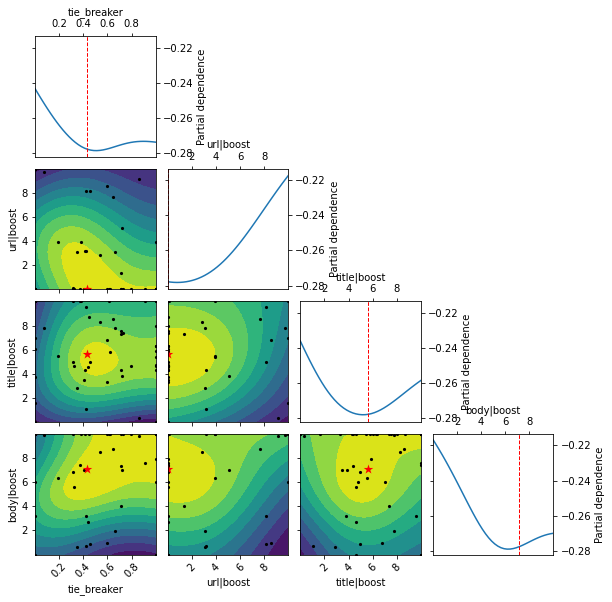

In [7]:
_ = plot_objective(metadata_best_fields, sample_source='result')

In [8]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id, params=final_params_best_fields)

Score: 0.3072
CPU times: user 1.98 s, sys: 447 ms, total: 2.43 s
Wall time: 1min 59s


This looks like the best score we've been able to achieve so far and it was a lot easier to tune than the `cross_fields` query type.